In [ ]:
#Ce fichier consiste à faire une analyse globale de la base de données principale ainsi que de créer un ou des modèles permettant d'attendre l'objectif (aider les utilisateurs à réaliser le tri avec des recommandation) 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Charger le fichier en testant différents séparateurs
file_path = "./fr_openfoodfacts.csv"
df = pd.read_csv(file_path, sep=',', low_memory=False)
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
0,54,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1582569031,2020-02-24T18:30:31Z,1733085204,2024-12-01T20:33:24Z,NaN,1736276870,2025-01-07T19:07:50Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1673620307,2023-01-13T14:31:47Z,1732913331,2024-11-29T20:48:51Z,insectproductadd,1736256588,2025-01-07T13:29:48Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,114,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1580066482,2020-01-26T19:21:22Z,1737247862,2025-01-19T00:51:02Z,smoothie-app,1737247862,2025-01-19T00:51:02Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,http://world-fr.openfoodfacts.org/produit/0000...,inf,1634745456,2021-10-20T15:57:36Z,1736961486,2025-01-15T17:18:06Z,smoothie-app,1736961486,2025-01-15T17:18:06Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1572117743,2019-10-26T19:22:23Z,1736849003,2025-01-14T10:03:23Z,prepperapp,1736849003,2025-01-14T10:03:23Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
#Voir les colonnes 
df.columns.to_list()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'last_modified_by',
 'last_updated_t',
 'last_updated_datetime',
 'product_name',
 'abbreviated_product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'packaging_fr',
 'packaging_text',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'origins_fr',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'ingredients_tags',
 'ingredients_analysis_tags',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'serving_quantity',
 'no_nutrition_data',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'nutriscore_score

In [62]:
#Nettoyage et structuration selon les données dont on a besoin
colonnes_utiles = [
    'code', 'product_name', 'categories_fr', 'packaging', 
    'countries_fr', 'nutrition-score-fr_100g', 'carbon-footprint_100g', 
    'popularity_tags', 'last_updated_datetime'
]

df = df[colonnes_utiles]

regions = ["Île-de-France", "Provence-Alpes-Côte d'Azur", "Bretagne", "Nouvelle-Aquitaine"]
communes = ["Paris", "Marseille", "Rennes", "Bordeaux"]

df['Région'] = [random.choice(regions) for _ in range(len(df))]
df['Commune'] = [random.choice(communes) for _ in range(len(df))]
df['Points bonus'] = df['popularity_tags'].apply(lambda x: random.randint(1, 10) if pd.notna(x) else 0)

# Sauvegarder le fichier préparé
df.to_csv("fr_openfoodfacts_final_ML.csv", index=False, encoding='utf-8')

df.head()

,code,product_name,categories_fr,packaging,countries_fr,nutrition-score-fr_100g,carbon-footprint_100g,popularity_tags,last_updated_datetime,Région,Commune,Points bonus
0,54,Limonade artisanale a la rose,NaN,NaN,France,NaN,NaN,NaN,2025-01-07T19:07:50Z,Provence-Alpes-Côte d'Azur,Marseille,0
1,63,Tablette Tanzanie,NaN,NaN,France,NaN,NaN,NaN,2025-01-07T13:29:48Z,Provence-Alpes-Côte d'Azur,Marseille,0
2,114,Chocolate n 3,NaN,NaN,France,NaN,NaN,"bottom-25-percent-scans-2022,bottom-20-percent...",2025-01-19T00:51:02Z,Bretagne,Bordeaux,4
3,1,Poulet fermier,en:clean-antioxidant-energy-drink,NaN,"France,Allemagne,États-Unis",1.0,NaN,NaN,2025-01-15T17:18:06Z,Île-de-France,Marseille,0
4,105,Paleta gran reserva - Sierra nevada-,"Boissons et préparations de boissons,Boissons",NaN,"Allemagne,Espagne",NaN,NaN,NaN,2025-01-14T10:03:23Z,Île-de-France,Marseille,0


## Analyse des données 

In [100]:
file_path = "./fr_openfoodfacts_final_ML.csv"
df_dechet = pd.read_csv(file_path)
df_dechet.head()
 

,code,product_name,categories_fr,packaging,countries_fr,nutrition-score-fr_100g,carbon-footprint_100g,popularity_tags,last_updated_datetime,Région,Commune,Points bonus
0,54,Limonade artisanale a la rose,NaN,NaN,France,NaN,NaN,NaN,2025-01-07T19:07:50Z,Provence-Alpes-Côte d'Azur,Marseille,0
1,63,Tablette Tanzanie,NaN,NaN,France,NaN,NaN,NaN,2025-01-07T13:29:48Z,Provence-Alpes-Côte d'Azur,Marseille,0
2,114,Chocolate n 3,NaN,NaN,France,NaN,NaN,"bottom-25-percent-scans-2022,bottom-20-percent...",2025-01-19T00:51:02Z,Bretagne,Bordeaux,4
3,1,Poulet fermier,en:clean-antioxidant-energy-drink,NaN,"France,Allemagne,États-Unis",1.0,NaN,NaN,2025-01-15T17:18:06Z,Île-de-France,Marseille,0
4,105,Paleta gran reserva - Sierra nevada-,"Boissons et préparations de boissons,Boissons",NaN,"Allemagne,Espagne",NaN,NaN,NaN,2025-01-14T10:03:23Z,Île-de-France,Marseille,0


In [64]:
#Remplir les colonnes vides et correction formats : 
#supprimer la colonne countries et replir les cases vides
df_dechet.drop(columns=['countries_fr'], inplace=True)
df_dechet['product_name'].fillna('Produit inconnu', inplace=True)
df_dechet['categories_fr'].fillna('Non spécifié', inplace=True)
df_dechet['packaging'].fillna('Non spécifié', inplace=True)
df_dechet['nutrition-score-fr_100g'].fillna(0, inplace=True)
df_dechet['carbon-footprint_100g'].fillna(0, inplace=True)
df_dechet['popularity_tags'].fillna('Aucune donnée', inplace=True)

#colonne last_updated_datetime : corriger son format 
df_dechet['last_updated_datetime'] = pd.to_datetime(df_dechet['last_updated_datetime'], errors='coerce')


C:\Users\sonia\AppData\Local\Temp\ipykernel_12360\2209084849.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dechet['product_name'].fillna('Produit inconnu', inplace=True)
C:\Users\sonia\AppData\Local\Temp\ipykernel_12360\2209084849.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [65]:
df_dechet.head()

,code,product_name,categories_fr,packaging,nutrition-score-fr_100g,carbon-footprint_100g,popularity_tags,last_updated_datetime,Région,Commune,Points bonus
0,54,Limonade artisanale a la rose,Non spécifié,Non spécifié,0.0,0.0,Aucune donnée,2025-01-07 19:07:50+00:00,Provence-Alpes-Côte d'Azur,Marseille,0
1,63,Tablette Tanzanie,Non spécifié,Non spécifié,0.0,0.0,Aucune donnée,2025-01-07 13:29:48+00:00,Provence-Alpes-Côte d'Azur,Marseille,0
2,114,Chocolate n 3,Non spécifié,Non spécifié,0.0,0.0,"bottom-25-percent-scans-2022,bottom-20-percent...",2025-01-19 00:51:02+00:00,Bretagne,Bordeaux,4
3,1,Poulet fermier,en:clean-antioxidant-energy-drink,Non spécifié,1.0,0.0,Aucune donnée,2025-01-15 17:18:06+00:00,Île-de-France,Marseille,0
4,105,Paleta gran reserva - Sierra nevada-,"Boissons et préparations de boissons,Boissons",Non spécifié,0.0,0.0,Aucune donnée,2025-01-14 10:03:23+00:00,Île-de-France,Marseille,0


In [66]:
#Garder le fichier clean pour le modèle 
df_dechet.to_csv("fr_openfoodfacts_cleaned.csv", index=False, encoding='utf-8')

## Partie nettoyage finie -----------------------------------------------------------------

In [98]:
#Analyse et modèle ML 
file_path = "./fr_openfoodfacts_cleaned.csv"
df_cleaned = pd.read_csv(file_path, sep=',', low_memory=False)
df_cleaned.head()

,code,product_name,categories_fr,packaging,nutrition-score-fr_100g,carbon-footprint_100g,popularity_tags,last_updated_datetime,Région,Commune,Points bonus
0,54,Limonade artisanale a la rose,Non spécifié,Non spécifié,0.0,0.0,Aucune donnée,2025-01-07 19:07:50+00:00,Provence-Alpes-Côte d'Azur,Marseille,0
1,63,Tablette Tanzanie,Non spécifié,Non spécifié,0.0,0.0,Aucune donnée,2025-01-07 13:29:48+00:00,Provence-Alpes-Côte d'Azur,Marseille,0
2,114,Chocolate n 3,Non spécifié,Non spécifié,0.0,0.0,"bottom-25-percent-scans-2022,bottom-20-percent...",2025-01-19 00:51:02+00:00,Bretagne,Bordeaux,4
3,1,Poulet fermier,en:clean-antioxidant-energy-drink,Non spécifié,1.0,0.0,Aucune donnée,2025-01-15 17:18:06+00:00,Île-de-France,Marseille,0
4,105,Paleta gran reserva - Sierra nevada-,"Boissons et préparations de boissons,Boissons",Non spécifié,0.0,0.0,Aucune donnée,2025-01-14 10:03:23+00:00,Île-de-France,Marseille,0


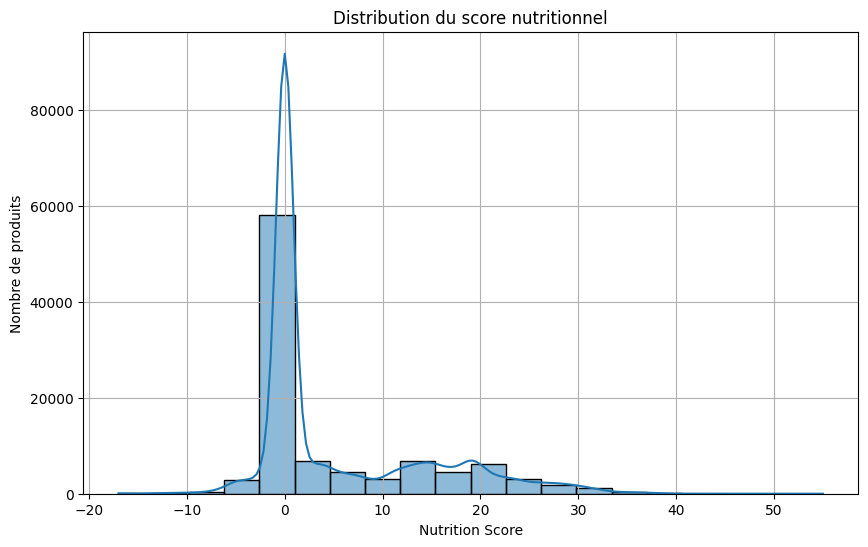

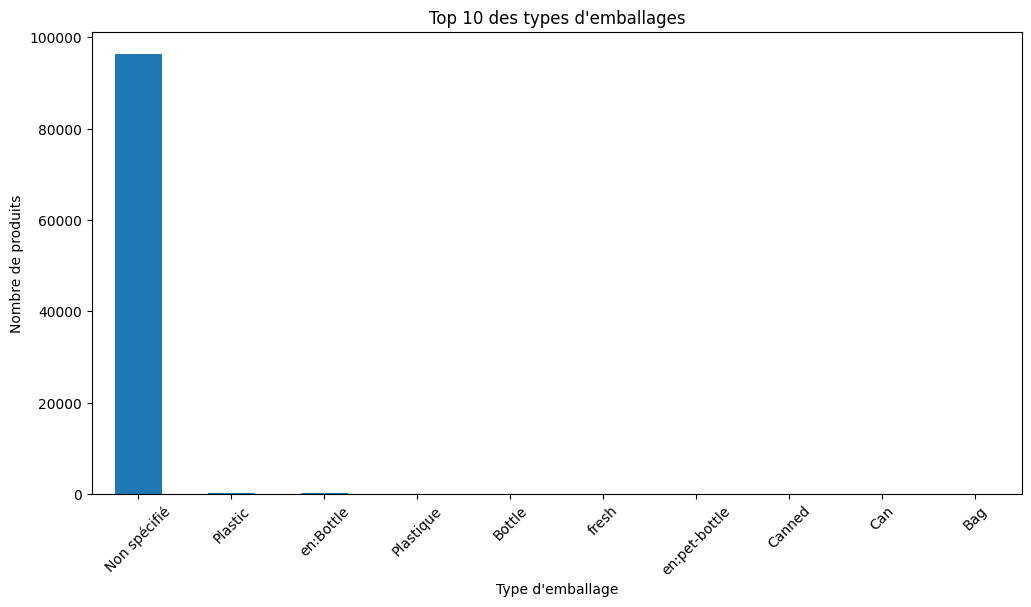

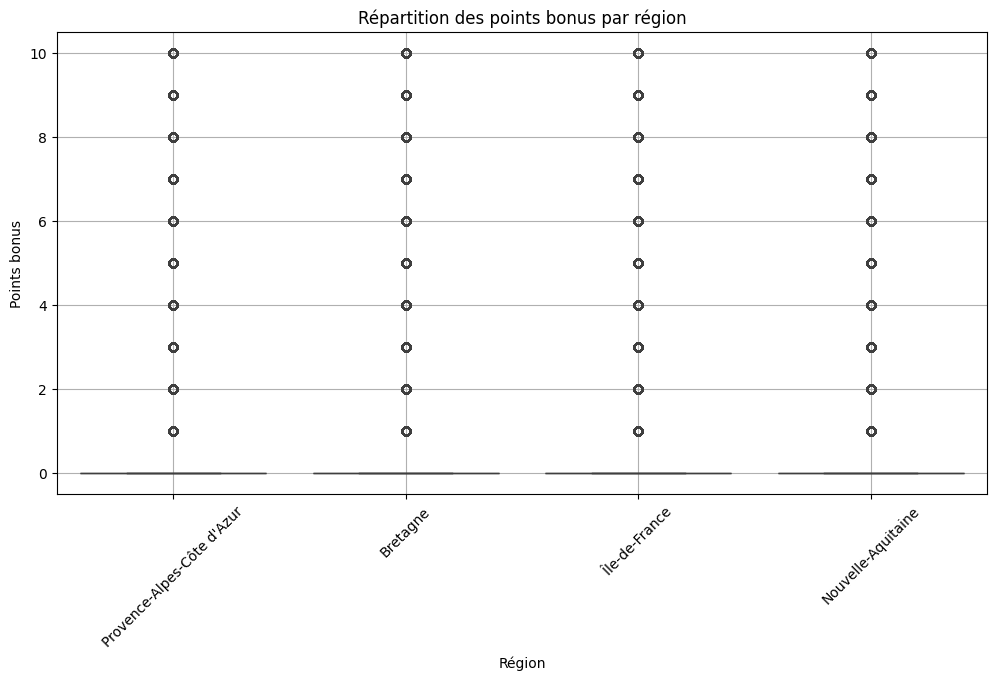

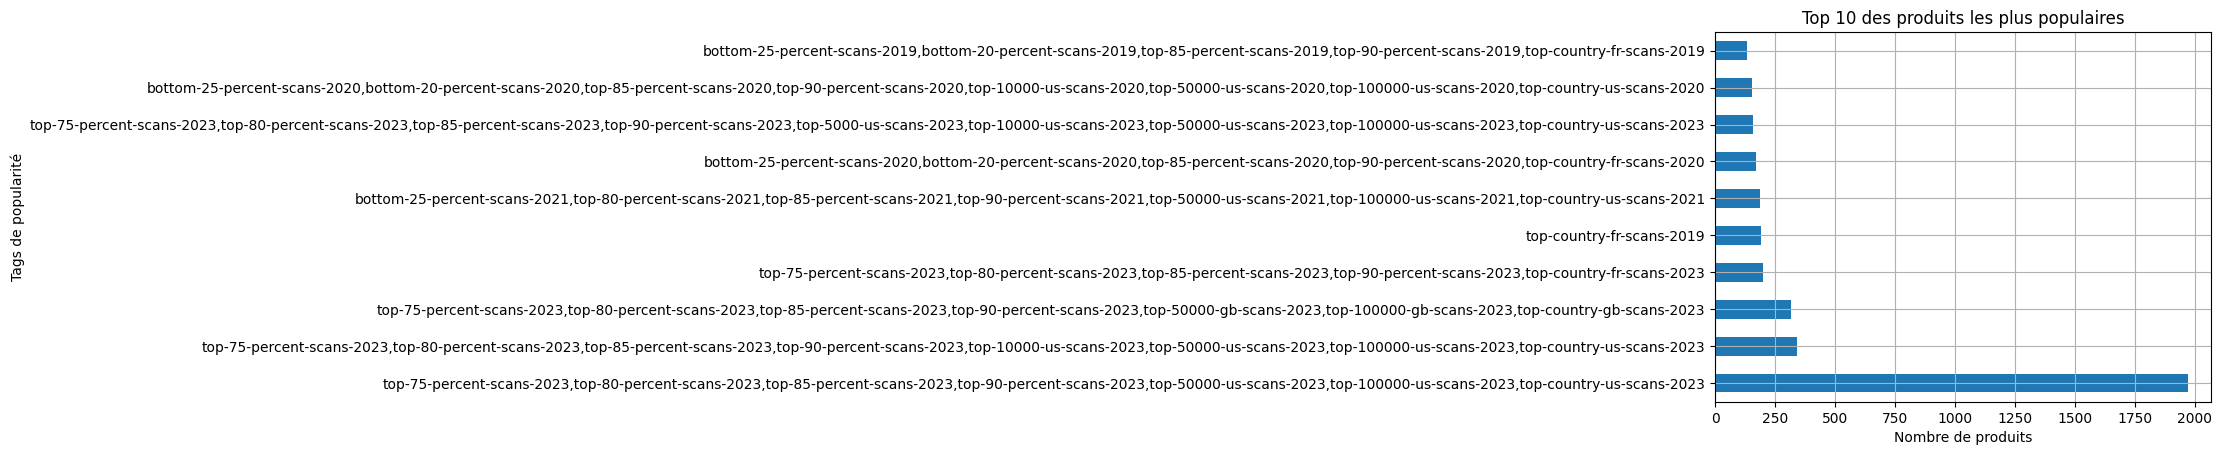

C:\Users\sonia\AppData\Local\Temp\ipykernel_12360\18402781.py:38: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_cleaned['year_month'] = df_cleaned['last_updated_datetime'].dt.to_period('M')


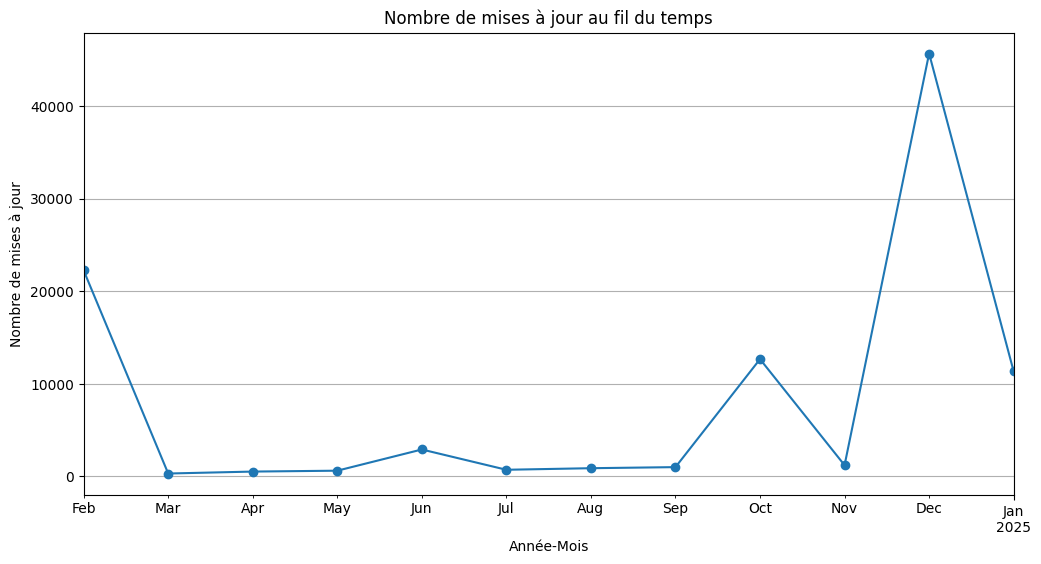

In [70]:
#Distribution des scores nutritionnels
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['nutrition-score-fr_100g'], bins=20, kde=True)
plt.title("Distribution du score nutritionnel")
plt.xlabel("Nutrition Score")
plt.ylabel("Nombre de produits")
plt.grid(True)
plt.show()

#Analyse des types de packaging
plt.figure(figsize=(12, 6))
df_cleaned['packaging'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 des types d'emballages")
plt.xlabel("Type d'emballage")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=45)
plt.show()

#Points bonus par région
plt.figure(figsize=(12, 6))
sns.boxplot(x="Région", y="Points bonus", data=df_cleaned)
plt.title("Répartition des points bonus par région")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#Produits les plus populaires (basés sur les tags de popularité)
popular_products = df_cleaned[df_cleaned['popularity_tags'] != 'Aucune donnée']
popular_products['popularity_tags'].value_counts().head(10).plot(kind='barh')
plt.title("Top 10 des produits les plus populaires")
plt.xlabel("Nombre de produits")
plt.ylabel("Tags de popularité")
plt.grid(True)
plt.show()

#Évolution des mises à jour au fil du temps
df_cleaned['last_updated_datetime'] = pd.to_datetime(df_cleaned['last_updated_datetime'])
df_cleaned['year_month'] = df_cleaned['last_updated_datetime'].dt.to_period('M')
plt.figure(figsize=(12, 6))
df_cleaned['year_month'].value_counts().sort_index().plot(kind='line', marker='o')
plt.title("Nombre de mises à jour au fil du temps")
plt.xlabel("Année-Mois")
plt.ylabel("Nombre de mises à jour")
plt.grid(True)
plt.show()

In [72]:
#Correlation entre la target et les autres colonnes (premières étapes àfin de réaliser un bon modèle)

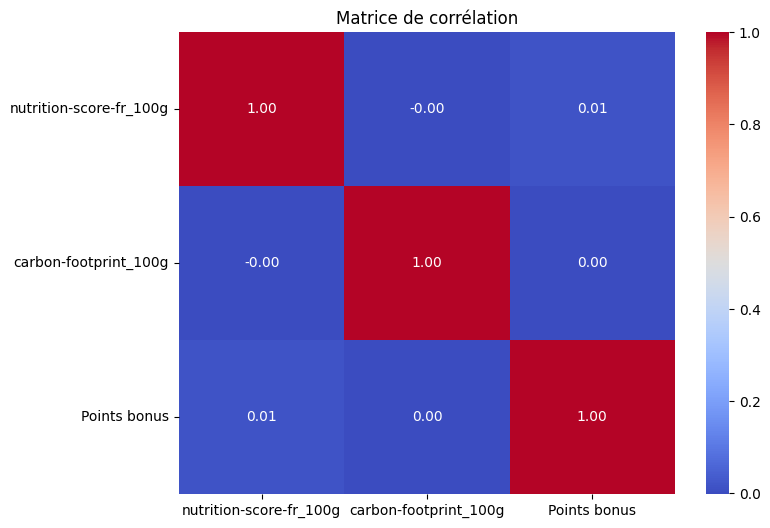

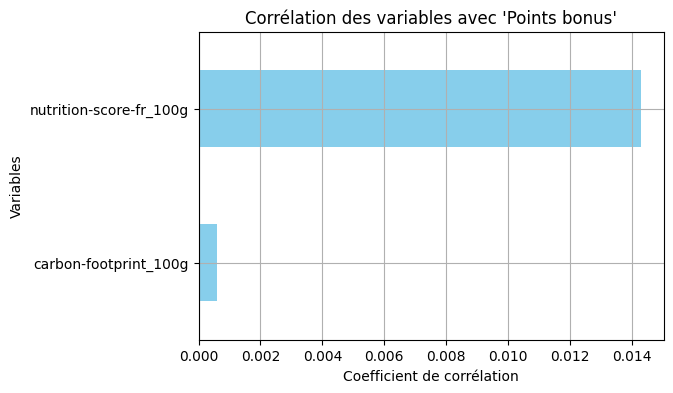

In [74]:
# Sélection des colonnes numériques pour la corrélation
df_corr = df_cleaned[['nutrition-score-fr_100g', 'carbon-footprint_100g', 'Points bonus']]
correlation_matrix = df_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.show()

target_correlation = df_corr.corr()['Points bonus'].drop('Points bonus')
plt.figure(figsize=(6, 4))
target_correlation.sort_values().plot(kind='barh', color='skyblue')
plt.title("Corrélation des variables avec 'Points bonus'")
plt.xlabel('Coefficient de corrélation')
plt.ylabel('Variables')
plt.grid()
plt.show()

Mean Squared Error: 1.06
R-squared: 0.73
                   Feature  Importance
3          popularity_tags    0.823785
0             product_name    0.070102
1            categories_fr    0.037074
6  nutrition-score-fr_100g    0.023549
5                  Commune    0.017131
4                   Région    0.016471
2                packaging    0.011880
7    carbon-footprint_100g    0.000007


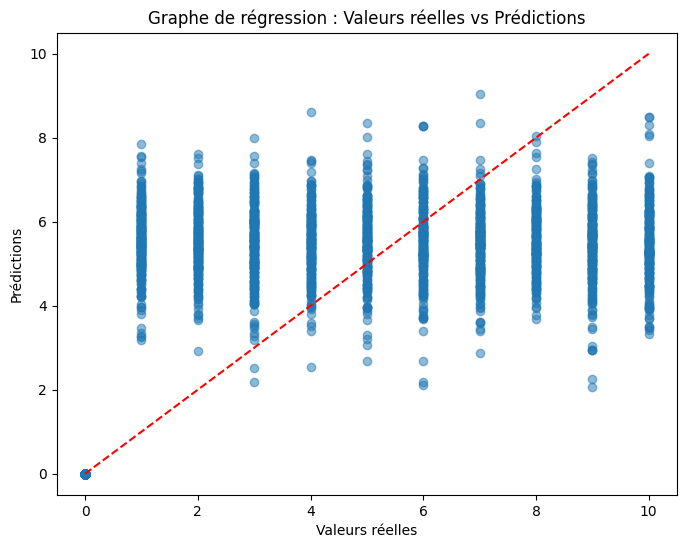

In [85]:
#Test premier modèle de regression 
#Sélection des colonnes pertinentes pour le modèle 
features = ['product_name', 'categories_fr', 'packaging', 'popularity_tags', 'Région', 'Commune', 'nutrition-score-fr_100g', 'carbon-footprint_100g']
target = 'Points bonus'

# Encoder les variables catégorielles
categorical_columns = ['product_name', 'categories_fr', 'packaging', 'popularity_tags', 'Région', 'Commune']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le
    
numerical_columns = ['nutrition-score-fr_100g', 'carbon-footprint_100g']
scaler = StandardScaler()
df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])

X = df_cleaned[features]
y = df_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importances.sort_values(by='Importance', ascending=False))

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Graphe de régression : Valeurs réelles vs Prédictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Ligne d'identité
plt.show()

Mean Squared Error: 3.5782976895958507
R-squared: 0.0897923030261436
                   Feature  Importance
2                packaging    0.436891
1            categories_fr    0.292094
0             product_name    0.177132
5  nutrition-score-fr_100g    0.064462
3                   Région    0.015823
4                  Commune    0.013598
6    carbon-footprint_100g    0.000000


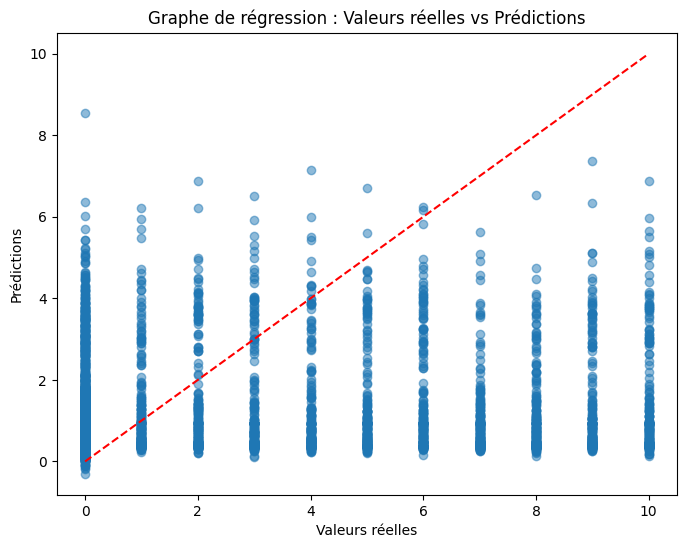

In [84]:
#test modèle 2: régression basé sur le boosting de gradient 
features = ['product_name', 'categories_fr', 'packaging', 'Région', 'Commune', 'nutrition-score-fr_100g', 'carbon-footprint_100g']
target = 'Points bonus'

categorical_columns = ['product_name', 'categories_fr', 'packaging', 'Région', 'Commune']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

numerical_columns = ['nutrition-score-fr_100g', 'carbon-footprint_100g']
scaler = StandardScaler()
df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])


X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Entraînement du modèle
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importances.sort_values(by='Importance', ascending=False))

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Graphe de régression : Valeurs réelles vs Prédictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Ligne d'identité
plt.show()

Accuracy: 0.90

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5309
           1       0.15      0.12      0.13        74
           2       0.08      0.10      0.09        61
           3       0.09      0.16      0.12        77
           4       0.13      0.09      0.10        69
           5       0.06      0.04      0.05        77
           6       0.08      0.06      0.07        68
           7       0.08      0.07      0.07        73
           8       0.11      0.05      0.07        78
           9       0.11      0.08      0.09        53
          10       0.10      0.21      0.13        61

    accuracy                           0.90      6000
   macro avg       0.18      0.18      0.17      6000
weighted avg       0.89      0.90      0.89      6000


Feature Importance:
                    Feature  Importance
3          popularity_tags    0.845344
2                packaging    0.047205
0       

C:\Users\sonia\AppData\Local\Temp\ipykernel_12360\3677013031.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], palette='viridis')


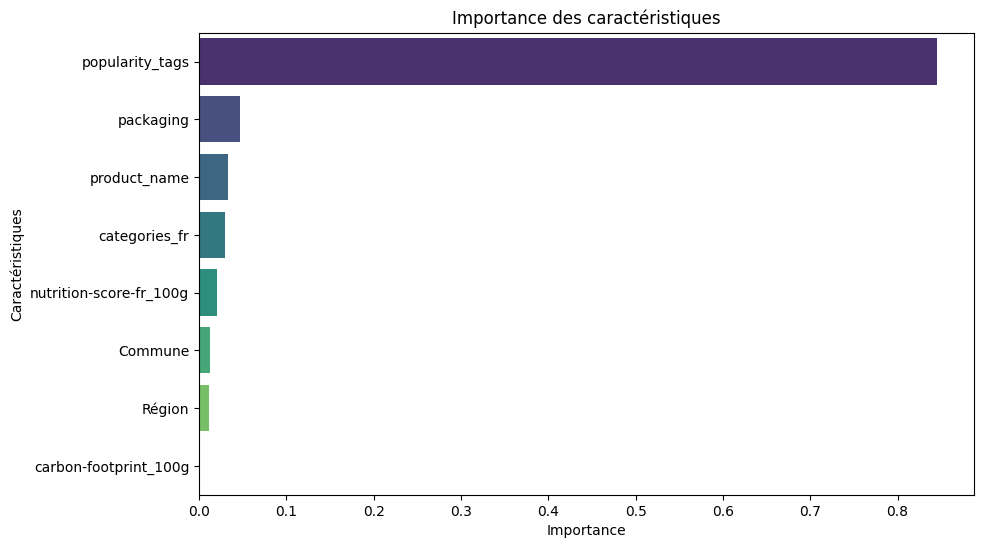

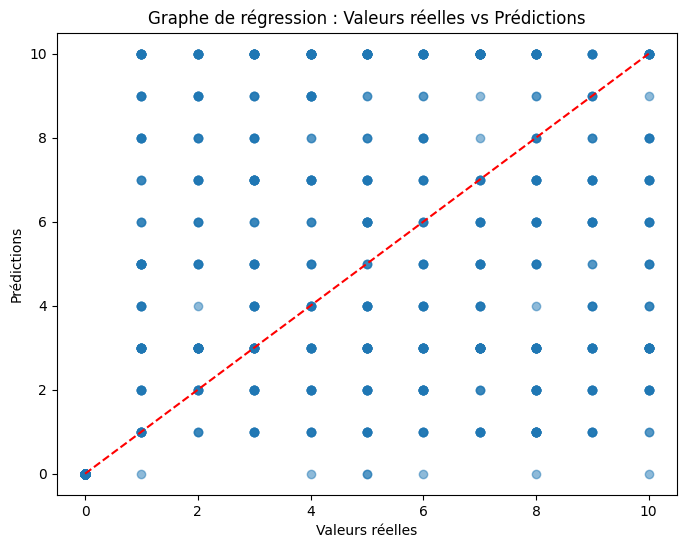

In [92]:
# test modèle 3 : RandomForestClassifier
features = ['product_name', 'categories_fr', 'packaging', 'popularity_tags', 'Région', 'Commune', 'nutrition-score-fr_100g', 'carbon-footprint_100g']
target = 'Points bonus'

df_sampled = df_cleaned.sample(frac=0.3, random_state=42)
categorical_columns = ['product_name', 'categories_fr', 'packaging', 'popularity_tags', 'Région', 'Commune']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_sampled[col] = le.fit_transform(df_sampled[col])
    label_encoders[col] = le

numerical_columns = ['nutrition-score-fr_100g', 'carbon-footprint_100g']
scaler = StandardScaler()
df_sampled[numerical_columns] = scaler.fit_transform(df_sampled[numerical_columns])


X = df_sampled[features]
y = df_sampled[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
model.fit(X_train, y_train)

#Prédictions et entrainement modèle
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], palette='viridis')
plt.title("Importance des caractéristiques")
plt.xlabel("Importance")
plt.ylabel("Caractéristiques")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Graphe de régression : Valeurs réelles vs Prédictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Ligne d'identité
plt.show()

In [93]:
#Télécharagement du modèle : 
joblib.dump(model, 'recycling_model_rf.pkl')

['recycling_model_rf.pkl']

In [94]:
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [95]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']